In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

In [2]:
npix = 5

yy_s, yy_e = 2002, 2012
# yy_s, yy_e = 2002, 2023

year_vector = np.arange(yy_s, yy_e+1)
years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [4]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [6]:
# these files were create from 6_DOWN_Bias.ipynb
total_years = np.arange(1980,2024)
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}.csv'
    Weibull_data = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_data[Weibull_data['Year'] == YY]['N'].values
        C_ = Weibull_data[Weibull_data['Year'] == YY]['C'].values
        W_ = Weibull_data[Weibull_data['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

In [7]:
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)

In [8]:
Tr = np.array([10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
Q_obs = np.zeros([len(wa_pd), len(Tr)])

for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]
    
    x0 = np.nanmean(N_)
    TMP_Q, flags = ART_down.mev_quant(Fi, x0, N_, C_, W_, thresh=1)
    TMP_Q = np.where(flags==True,TMP_Q,np.nan)
    Q_obs[nn,:] = TMP_Q

new_df = pd.DataFrame(Q_obs, columns=['Q10','Q20','Q50','Q100','Q200'])
wa_pd = pd.concat([wa_pd, new_df], axis=1)
wa_pd = wa_pd.drop(columns=["index"])

ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0


In [9]:
frac = 1

Q_80 = wa_pd.sample(frac=frac, random_state=42)
Q_80 = Q_80.reset_index(drop=True)

Q_20 = wa_pd.drop(Q_80.index)
Q_20 = Q_20.reset_index(drop=True)

print(f'Number of Stations: {len(wa_pd)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 209
80% DataFrame: 209
20% DataFrame: 0


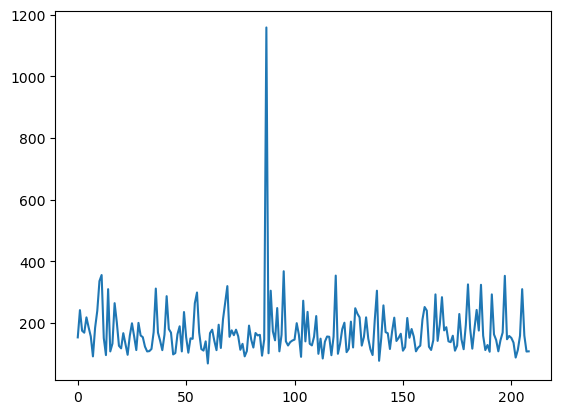

In [10]:
plt.plot(Q_80['Q50'])

In [11]:
wa_filter = Q_80[Q_80['Q50']<=380]
wa_filter = wa_filter.reset_index(drop=True)

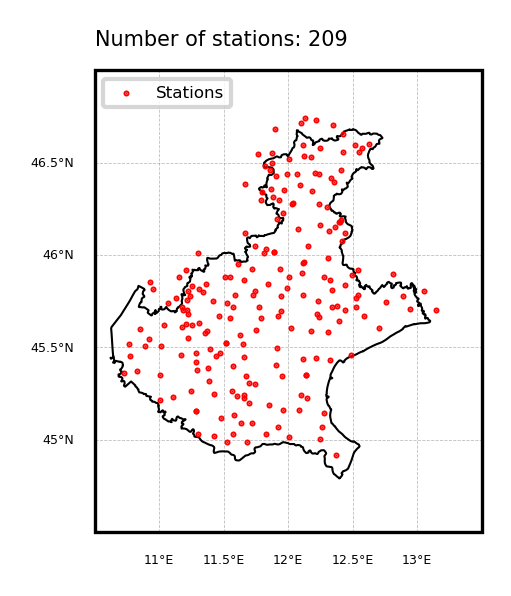

In [12]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

ax1.scatter(Q_80['Lon'].values, Q_80['Lat'].values, s=0.2, c='r', zorder=20, label='Stations')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True

gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title(f'Number of stations: {len(Q_80)}', loc='left', fontsize=5)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [13]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

## IMERG

In [33]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_5.nc')
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_IMERG_3h_{yy_s}_{yy_e}_npix_5_v3.nc')
DATA = xr.open_dataset(data_dir)

lon_IMERG, lat_IMERG  = np.meshgrid(DATA.lon.values, DATA.lat.values)
Tr = DATA['Tr'].values

# Q_IMERG = DATA.Quantile.values
Q_IMERG = DATA.Quantile.values
del DATA
Q_IMERG.shape

(5, 25, 30)

## MSWEP

In [34]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_MSWEP_3h_{yy_s}_{yy_e}_npix_5.nc')
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_MSWEP_3h_{yy_s}_{yy_e}_npix_5_v3.nc')
DATA = xr.open_dataset(data_dir)

lon_MSWEP, lat_MSWEP  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_MSWEP = DATA.Quantile.values
del DATA
Q_MSWEP.shape

(5, 25, 30)

## CMORPH

In [35]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_5.nc')
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_5_v3.nc')
DATA = xr.open_dataset(data_dir)

lon_CMORPH, lat_CMORPH  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_CMORPH = DATA.Quantile.values
del DATA
Q_CMORPH.shape

(5, 10, 12)

## ERA5

In [36]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_ERA5_3h_{yy_s}_{yy_e}_npix_5.nc')
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_ERA5_3h_{yy_s}_{yy_e}_npix_5_v3.nc')
DATA = xr.open_dataset(data_dir)

lon_ERA5, lat_ERA5  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_ERA5 = DATA.Quantile.values
del DATA
Q_ERA5.shape

(5, 11, 13)

## GSMaP

In [37]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_GSMaP_3h_{yy_s}_{yy_e}_npix_5.nc')
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_GSMaP_3h_{yy_s}_{yy_e}_npix_5_v3.nc')
DATA = xr.open_dataset(data_dir)

lon_GMSaP, lat_GMSaP  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_GMSaP = DATA.Quantile.values
del DATA
Q_GMSaP.shape

(5, 25, 30)

## SM2RAIN

In [38]:
data_dir = os.path.join(data_base,'3_DOWN','VENETO_DOWN_SM2RAIN_1dy_2007_2012_npix_5.nc')
DATA = xr.open_dataset(data_dir)

lon_SM2RAIN, lat_SM2RAIN  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_SM2RAIN = DATA.Quantile.values
# del DATA
Q_SM2RAIN.shape

(5, 26, 31)

## PERSIANN

In [39]:
data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_PERSIANN_1dy_{yy_s}_{yy_e}_npix_5_v2.nc')
DATA = xr.open_dataset(data_dir)

lon_PERSIANN, lat_PERSIANN  = np.meshgrid(DATA.lon.values, DATA.lat.values)

Q_PERSIANN = DATA.Quantile.values
# del DATA
Q_PERSIANN.shape

(5, 10, 12)

In [40]:
# Tr_index, Q_index = 0, 'Q10'
# Tr_index, Q_index = 1, 'Q20'
Tr_index, Q_index = 2, 'Q50'
# Tr_index, Q_index = 3, 'Q100'
# Tr_index, Q_index = 4, 'Q200'

colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange']

In [41]:
E_IMERG, E_CMORPH, E_MSWEP, E_ERA5, E_GMSaP, E_SM2RAIN, E_PERSIANN = [], [], [], [], [], [], []
E_ESEMBLE, ensemble_list = [], []

for nn in range(len(wa_filter)):
    Q_OBS = wa_filter[Q_index].values[nn]
    lat_obs = wa_filter['Lat'].values[nn]
    lon_obs = wa_filter['Lon'].values[nn]

    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    IMERG_val = Q_IMERG[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (IMERG_val - Q_OBS)/Q_OBS
    E_IMERG.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    CMORPH_val = Q_CMORPH[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (CMORPH_val - Q_OBS)/Q_OBS
    E_CMORPH.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    MSWEP_val = Q_MSWEP[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (MSWEP_val - Q_OBS)/Q_OBS
    E_MSWEP.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    ERA5_val = Q_ERA5[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (ERA5_val - Q_OBS)/Q_OBS
    E_ERA5.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_GMSaP, lon_GMSaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    GMSaP_val = Q_GMSaP[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (GMSaP_val - Q_OBS)/Q_OBS
    E_GMSaP.append(float(ERROR_))
    
    distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    SM2RAIN_val = Q_SM2RAIN[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (SM2RAIN_val - Q_OBS)/Q_OBS
    E_SM2RAIN.append(float(ERROR_))

    distances = ART_pre.haversine(lat_PERSIANN, lon_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    PERSIANN_val = Q_PERSIANN[Tr_index,min_index[0],min_index[1]]
    ERROR_ = (PERSIANN_val - Q_OBS)/Q_OBS
    E_PERSIANN.append(float(ERROR_))

    SAT_BET_mean = np.nanmean(
                        [IMERG_val,
                        CMORPH_val,
                        MSWEP_val,
                        ERA5_val,
                        GMSaP_val]
                        )
    E_ESEMBLE_ = (SAT_BET_mean - Q_OBS)/Q_OBS
    E_ESEMBLE.append(E_ESEMBLE_)
    
    ensemble_list.append({
        'Lat': lat_obs,
        'Lon': lon_obs,
        'OBS': Q_OBS,
        'IMERG': IMERG_val,
        'CMORPH': CMORPH_val,
        'MSWEP': MSWEP_val,
        'ERA5': ERA5_val,
        'GSMaP': GMSaP_val,
        'SM2RAIN': SM2RAIN_val,
        'PERSIANN':PERSIANN_val,
        'ENSEMBLE': SAT_BET_mean
    })

SATELLITE_pd = pd.DataFrame(ensemble_list)

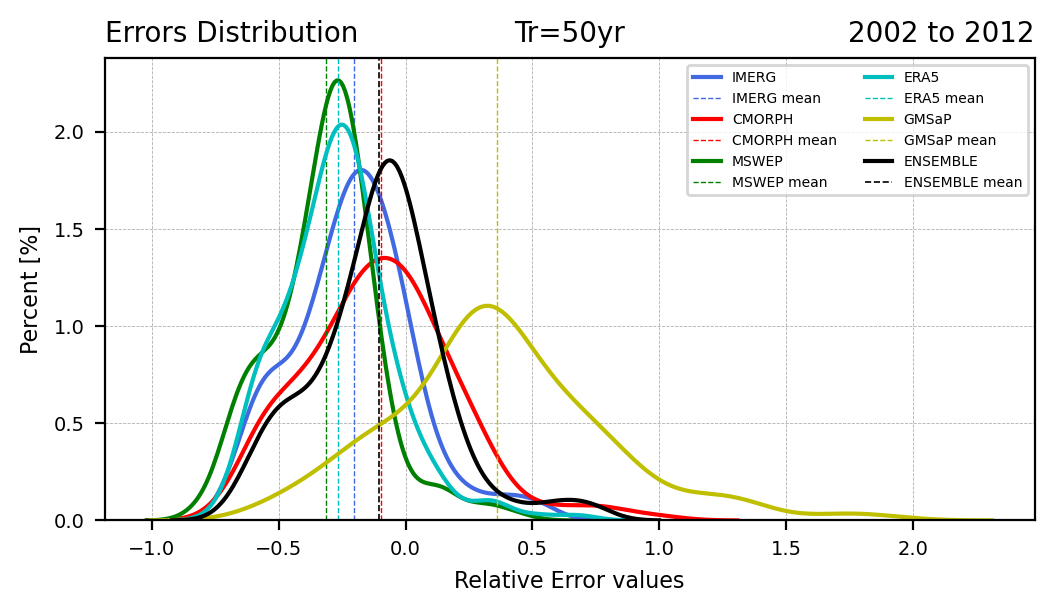

In [42]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(E_IMERG,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
ax1.axvline(np.nanmean(E_IMERG), color=colors[0], linestyle='--', linewidth=0.5, label='IMERG mean')

sns.kdeplot(E_CMORPH,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
ax1.axvline(np.nanmean(E_CMORPH), color=colors[1], linestyle='--', linewidth=0.5, label='CMORPH mean')

sns.kdeplot(E_MSWEP,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
ax1.axvline(np.nanmean(E_MSWEP), color=colors[2], linestyle='--', linewidth=0.5, label='MSWEP mean')

sns.kdeplot(E_ERA5,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
ax1.axvline(np.nanmean(E_ERA5), color=colors[3], linestyle='--', linewidth=0.5, label='ERA5 mean')

sns.kdeplot(E_GMSaP,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GMSaP')
ax1.axvline(np.nanmean(E_GMSaP), color=colors[4], linestyle='--', linewidth=0.5, label='GMSaP mean')

# sns.kdeplot(E_SM2RAIN,color=colors[5],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SM2RAIN')
# ax1.axvline(np.nanmean(E_SM2RAIN), color=colors[5], linestyle='--', linewidth=0.5, label='SM2RAIN mean')

# sns.kdeplot(E_PERSIANN,color=colors[6],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN')
# ax1.axvline(np.nanmean(E_PERSIANN), color=colors[6], linestyle='--', linewidth=0.5, label='PERSIANN mean')

sns.kdeplot(E_ESEMBLE,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE')
ax1.axvline(np.nanmean(E_ESEMBLE), color='k', linestyle='--', linewidth=0.6, label='ENSEMBLE mean')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=0, ncol=2)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Errors Distribution', fontsize=10, loc='left')
ax1.set_title(f'Tr={Tr[Tr_index]}yr',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

# =========================================================================================================================
ax1.set_facecolor('white')
# fig.patch.set_alpha(0)

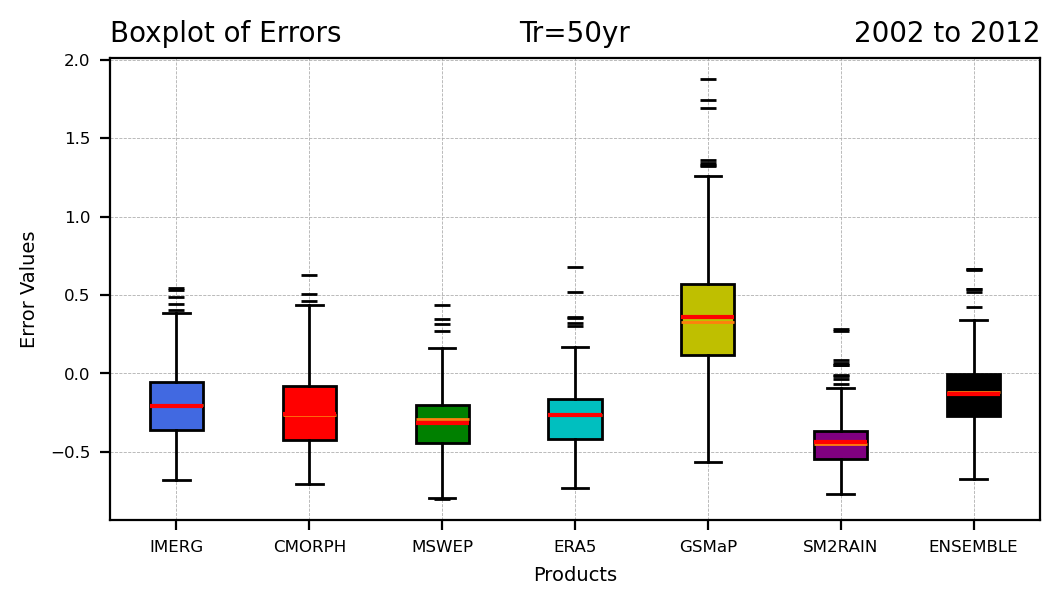

In [24]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

boxes = []
medians = []
mean = []
fliers = []

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

box = ax1.boxplot(np.array(E_IMERG)[~np.isnan(E_IMERG)],positions=[0],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[0],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(E_CMORPH)[~np.isnan(E_CMORPH)],positions=[1],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[1],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(E_MSWEP)[~np.isnan(E_MSWEP)],positions=[2],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[2],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(E_ERA5)[~np.isnan(E_ERA5)],positions=[3],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[3],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(E_GMSaP)[~np.isnan(E_GMSaP)],positions=[4],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[4],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(E_SM2RAIN)[~np.isnan(E_SM2RAIN)],positions=[5],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[5],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(E_ESEMBLE)[~np.isnan(E_ESEMBLE)],positions=[6],vert=True,
    widths=0.4,boxprops=dict(facecolor='k',color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

ax1.set_xticks([0,1,2,3,4,5,6])
ax1.set_xticklabels(['IMERG','CMORPH','MSWEP','ERA5','GSMaP','SM2RAIN', 'ENSEMBLE'],fontsize=6)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlabel('Products',fontsize=7)
ax1.set_ylabel('Error Values',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('Boxplot of Errors', fontsize=10, loc='left')
ax1.set_title(f'Tr={Tr[Tr_index]}yr',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [25]:
E_IMERG_M = np.ones_like(Q_IMERG[0,:,:])*np.nan
E_CMORPH_M = np.ones_like(Q_CMORPH[0,:,:])*np.nan
E_MSWEP_M = np.ones_like(Q_MSWEP[0,:,:])*np.nan
E_ERA5_M = np.ones_like(Q_ERA5[0,:,:])*np.nan
E_GMSaP_M = np.ones_like(Q_GMSaP[0,:,:])*np.nan
E_SM2RAIN_M = np.ones_like(Q_SM2RAIN[0,:,:])*np.nan
E_ENSEMBLE_M = np.ones_like(Q_IMERG[0,:,:])*np.nan

for nn in range(len(wa_filter)):
    Q_OBS = wa_filter[Q_index].values[nn]
    lat_obs = wa_filter['Lat'].values[nn]
    lon_obs = wa_filter['Lon'].values[nn]

    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_IMERG_M[min_index[0],min_index[1]] = 100*(Q_IMERG[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_CMORPH_M[min_index[0],min_index[1]] = 100*(Q_CMORPH[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_MSWEP_M[min_index[0],min_index[1]] = 100*(Q_MSWEP[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_ERA5_M[min_index[0],min_index[1]] = 100*(Q_ERA5[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_GMSaP, lon_GMSaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_GMSaP_M[min_index[0],min_index[1]] = 100*(Q_GMSaP[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_SM2RAIN_M[min_index[0],min_index[1]] = 100*(Q_SM2RAIN[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

In [26]:
products = SATELLITE_pd.columns.values[3:8]
letter = ['(a)','(d)', '(b)', '(e)', '(c)', '(f)']

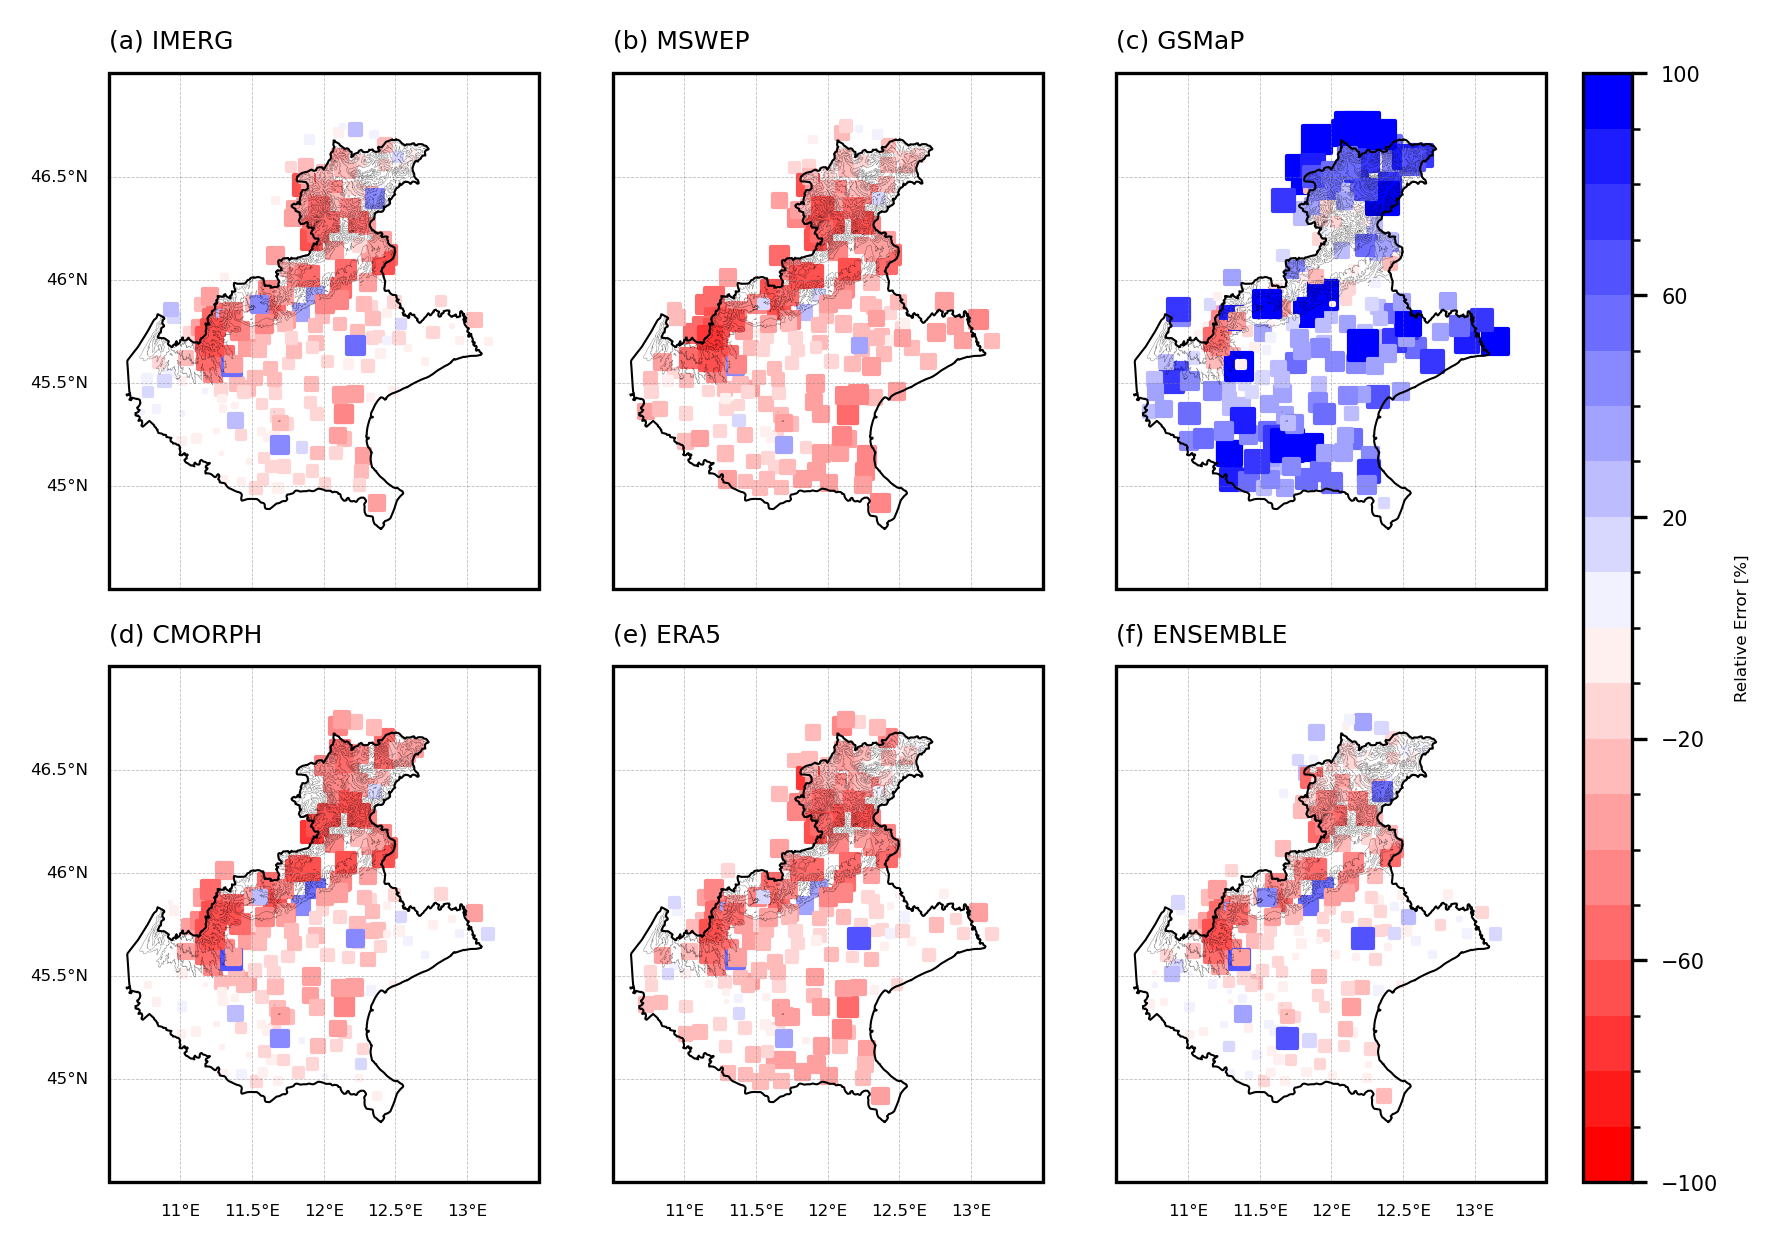

In [27]:
# levels = np.arange(-1.0,1.2,0.2)
# norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
# ticks = np.arange(-1,1.4,0.4)

levels = np.arange(-100,110,10)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
ticks = np.arange(-100,140,40)

cmap = plt.cm.Spectral_r
cmap = plt.cm.bwr_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6.5,4.8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
pos = 0
count = 1
for ncol in range(3):
    for nrow in range(2):
        ax_name = f"ax{count}"
        globals()[ax_name] = plt.subplot(gs[nrow, ncol], projection=proj)
        globals()[ax_name].set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
        VENETO.plot(facecolor='None', ax=globals()[ax_name], linewidth=0.5, zorder=10)
        DEM.plot(facecolor='None', ax=globals()[ax_name], zorder=10, linewidth=0.1, color='k', alpha=0.5)
        
        if nrow == 1 and ncol == 2:
            a1 = globals()[ax_name].scatter(SATELLITE_pd['Lon'],
                SATELLITE_pd['Lat'],
                s=abs(100*(SATELLITE_pd['ENSEMBLE']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS'])/3,
                c=(100*(SATELLITE_pd['ENSEMBLE']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']),
                marker='s',
                cmap=cmap,norm=norm)
        
        else:
            a1 = globals()[ax_name].scatter(SATELLITE_pd['Lon'],
                SATELLITE_pd['Lat'],
                s=abs(100*(SATELLITE_pd[products[pos]]-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS'])/3,
                c=(100*(SATELLITE_pd[products[pos]]-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']),
                marker='s',
                cmap=cmap,norm=norm)

        gl = globals()[ax_name].gridlines(crs=proj,draw_labels=False,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
        if ncol == 0:
            gl.left_labels = True
        else:
            gl.left_labels = False
        if nrow == 0:
            gl.bottom_labels = False
        else:
            gl.bottom_labels = True
        gl.xlabel_style = {'size': 4, 'color': 'k'}
        gl.ylabel_style = {'size': 4, 'color': 'k'}

        # globals()[ax_name].set_title(f"{letter[pos]} {products[pos]}", fontsize=6, loc='left')
        
        if pos ==5:
            globals()[ax_name].set_title(f"(f) ENSEMBLE", fontsize=6, loc='left')
        else:
            globals()[ax_name].set_title(f"{letter[pos]} {products[pos]}", fontsize=6, loc='left')
        
        # cbar = plt.colorbar(a1, ticks=ticks, fraction=0.053)
        # cbar.set_label('Relative Error [%]',fontsize=4)
        # cbar.ax.tick_params(labelsize=4)

        count += 1
        pos += 1
# ==============================================================================
# ax1.set_title(f'Relative Error', fontsize=6, loc='right')
cbar_ax = fig.add_axes([0.9, 0.11, 0.025, 0.77])#0.91
cbar = plt.colorbar(a1, cax=cbar_ax, ticks= ticks, orientation='vertical')
cbar.set_label('Relative Error [%]',fontsize=4)
cbar.ax.tick_params(labelsize=5)

# ==============================================================================
plt.subplots_adjust(wspace=0, hspace=0.15)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [28]:
Q_IMERG_list = []
Q_CMORPH_list = []
Q_MSWEP_list = []
Q_ERA5_list = []
Q_GMSaP_list = []
Q_SM2RAIN_list = []
for nn in range(len(wa_filter)):
    lat_obs = wa_filter['Lat'].values[nn]
    lon_obs = wa_filter['Lon'].values[nn]

    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_IMERG_list.append(float(Q_IMERG[Tr_index,min_index[0],min_index[1]]))
    
    distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_CMORPH_list.append(Q_CMORPH[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_MSWEP_list.append(Q_MSWEP[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_ERA5_list.append(Q_ERA5[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_GMSaP, lon_GMSaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_GMSaP_list.append(Q_GMSaP[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_SM2RAIN_list.append(Q_SM2RAIN[Tr_index,min_index[0],min_index[1]])

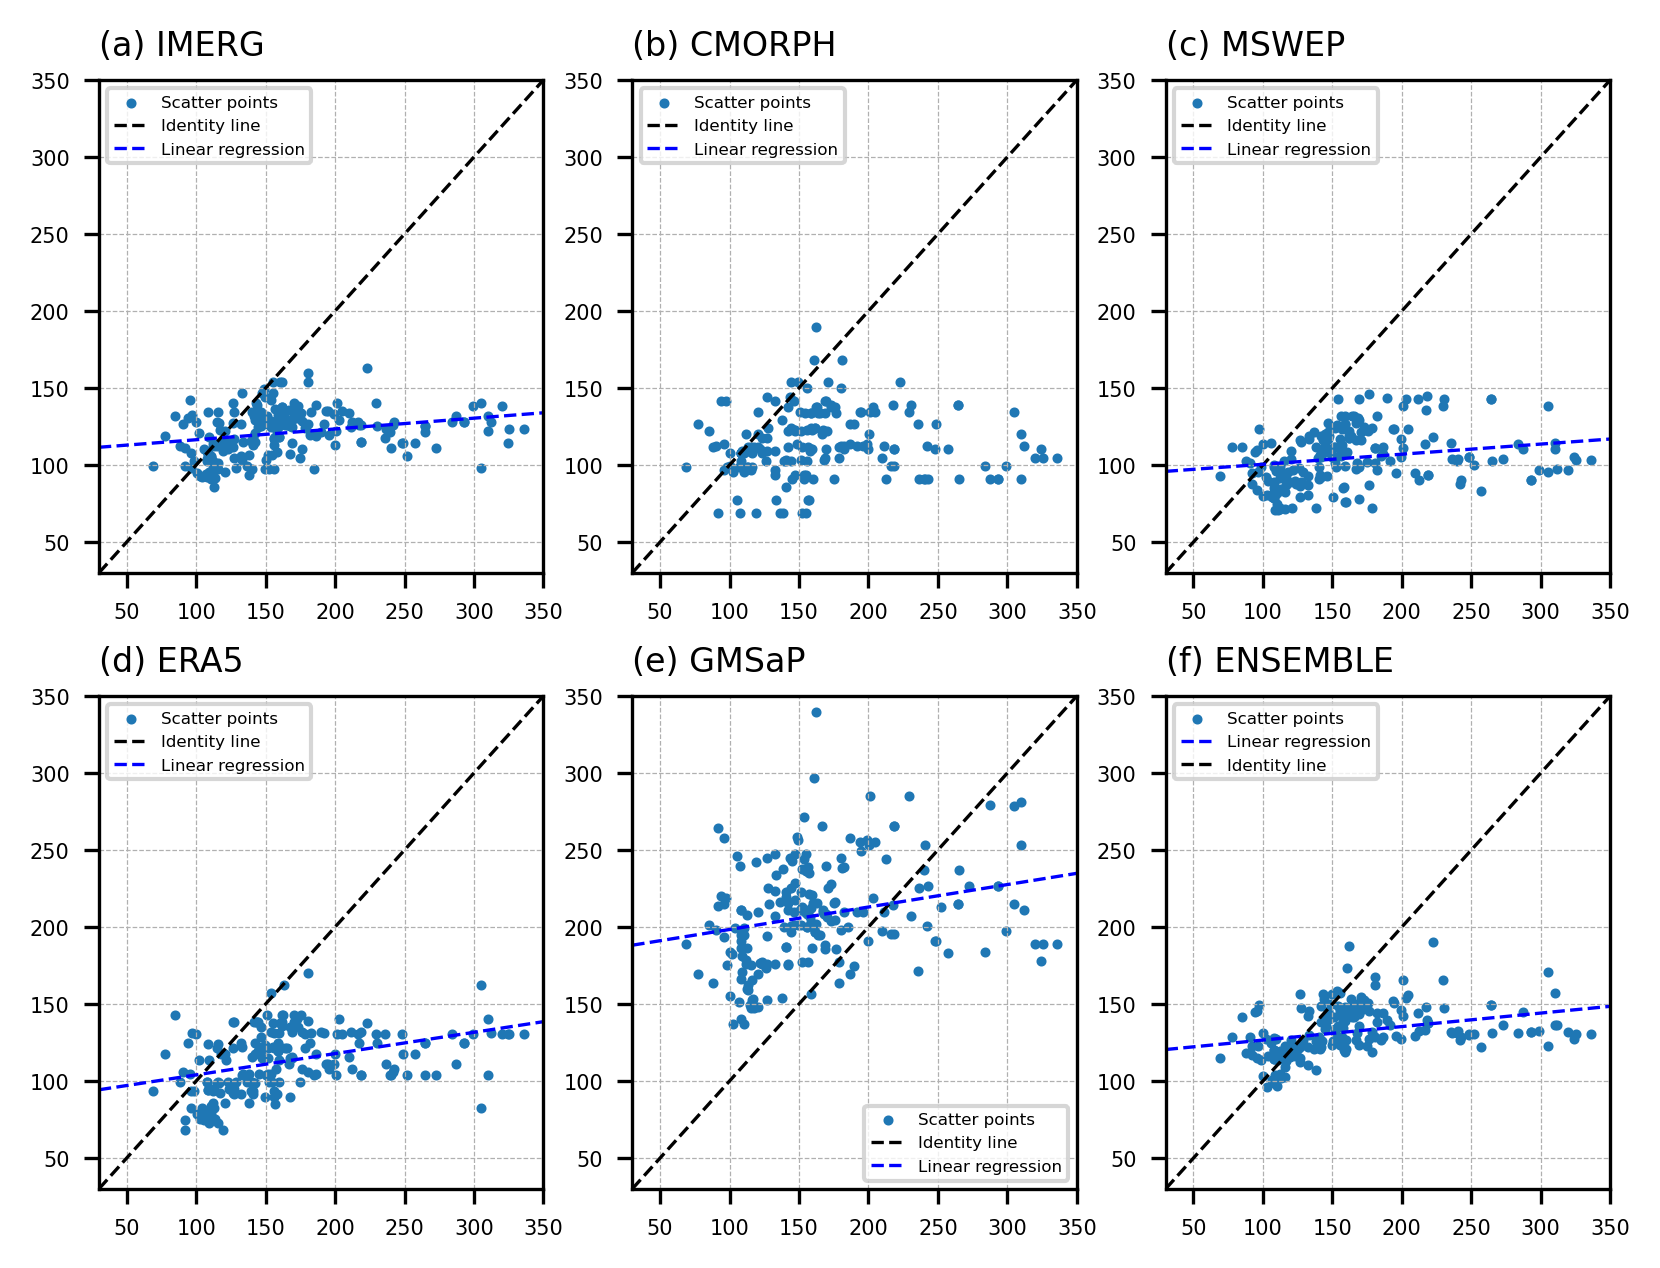

In [29]:
lmin, lmax = 30, 350

xx = np.arange(lmin,lmax+10,10)

fig = plt.figure(figsize=(6.5,4.8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['IMERG'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['IMERG'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['IMERG'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['IMERG'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(a) IMERG', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['CMORPH'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['CMORPH'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['CMORPH'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['CMORPH'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(b) CMORPH', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['MSWEP'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['MSWEP'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['MSWEP'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['MSWEP'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(c) MSWEP', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 0])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['ERA5'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['ERA5'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['ERA5'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['ERA5'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(d) ERA5', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['GSMaP'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['GSMaP'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['GSMaP'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['GSMaP'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(e) GMSaP', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['ENSEMBLE'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['ENSEMBLE'])])
a = np.array(SATELLITE_pd['OBS'])[np.array(SATELLITE_pd['ENSEMBLE'])!=0]
b = np.array(SATELLITE_pd['ENSEMBLE'])[np.array(SATELLITE_pd['ENSEMBLE'])!=0]
ax1.scatter(a, b, s=2, label='Scatter points')
slope, intercept, _, _, _ = stats.linregress(a[~np.isnan(b)], b[~np.isnan(b)])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.set_title('(f) ENSEMBLE', fontsize=8, loc='left')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.25, wspace=0.2)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

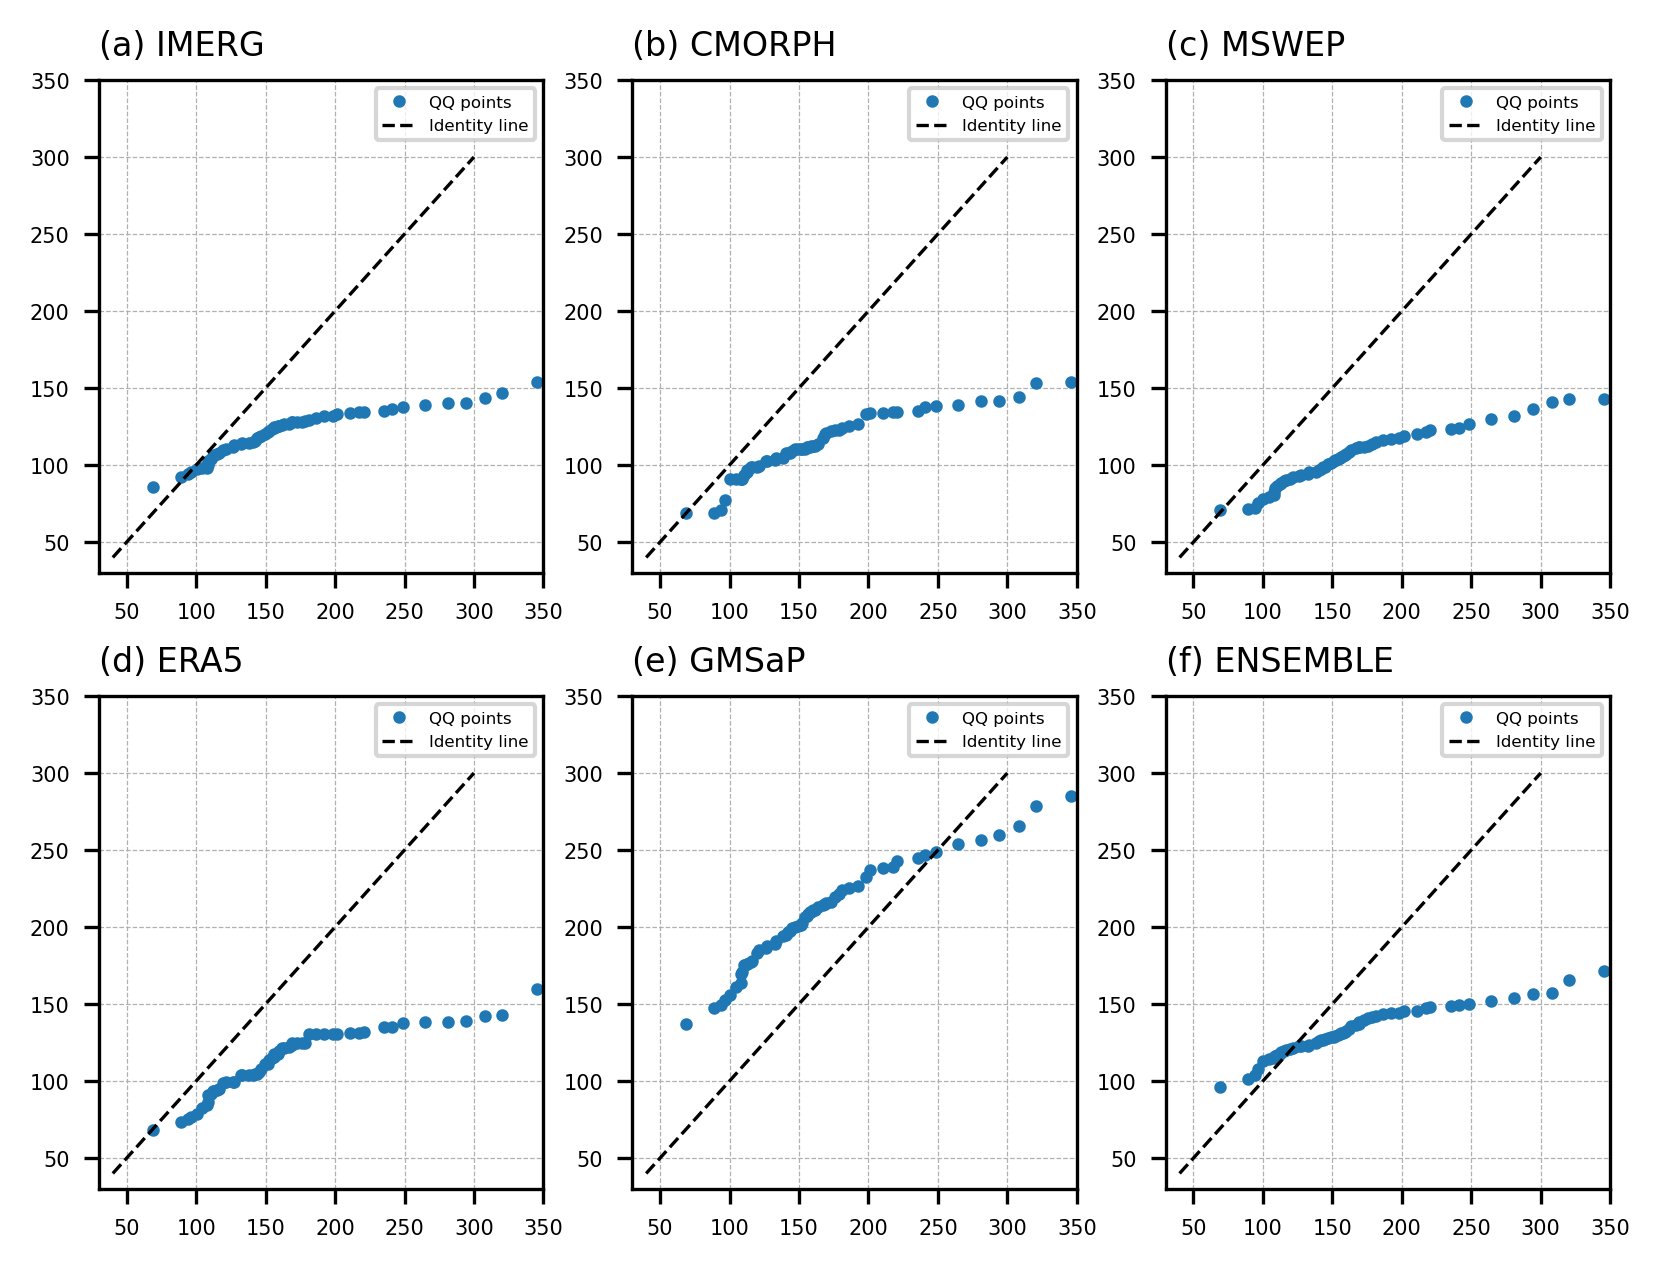

In [30]:
percs = np.linspace(0,100,61)
x = np.linspace(40,300)

fig = plt.figure(figsize=(6.5,4.8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['IMERG'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(a) IMERG', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['CMORPH'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(b) CMORPH', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['MSWEP'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(c) MSWEP', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 0])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['ERA5'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(d) ERA5', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['GSMaP'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(e) GMSaP', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['ENSEMBLE'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(f) ENSEMBLE', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.25, wspace=0.2)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)